<a href="https://colab.research.google.com/github/Khaled-Mohammed-Abdelgaber/DR-mostafa/blob/main/master_variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.layers import *
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.models import Model

In [2]:
#first to mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data preparation

In [3]:
ECG1 = pd.read_csv("/content/drive/MyDrive/data/peak2peak_aug_2022/Part_1/10_beat_signals/part_1_ECG_signals_10_beats_Aug_2022.csv",
                   names = np.arange(1024))
PPG1 = pd.read_csv("/content/drive/MyDrive/data/peak2peak_aug_2022/Part_1/10_beat_signals/part_1_PPG_signals_10_beats_Aug_2022.csv",
                   names = np.arange(1024))

PPG2 = pd.read_csv("/content/drive/MyDrive/data/peak2peak_aug_2022/Part_2/10_beat_signals/part_2_PPG_signals_10_beats_Aug_2022.csv",
                   names = np.arange(1024))
ECG2= pd.read_csv("/content/drive/MyDrive/data/peak2peak_aug_2022/Part_2/10_beat_signals/part_2_ECG_signals_10_beats_Aug_2022.csv",
                  names = np.arange(1024))

In [4]:
PPG1.head

<bound method NDFrame.head of           0        1        2        3        4        5        6        7     \
0      0.93827  0.93797  0.93668  0.93271  0.92657  0.91835  0.90804  0.89557   
1      0.97918  0.97711  0.97282  0.96595  0.95673  0.94525  0.93125  0.91482   
2      0.91117  0.91058  0.90876  0.90415  0.89734  0.88842  0.87828  0.86690   
3      0.94427  0.94437  0.94375  0.94039  0.93489  0.92729  0.91784  0.90638   
4      0.88354  0.88384  0.88364  0.88063  0.87566  0.86903  0.86046  0.84995   
...        ...      ...      ...      ...      ...      ...      ...      ...   
15449  0.78430  0.78038  0.76978  0.75210  0.72821  0.69945  0.66660  0.62988   
15450  0.90737  0.90385  0.89257  0.87655  0.85532  0.82831  0.79768  0.76319   
15451  0.76031  0.75323  0.74221  0.72365  0.69896  0.67104  0.64018  0.60524   
15452  0.81240  0.80645  0.79196  0.76904  0.74286  0.71647  0.68736  0.65579   
15453  0.95312  0.94935  0.93602  0.91353  0.88318  0.84679  0.80640  0.76175  

In [5]:
PPG = pd.concat([PPG1 , PPG2],keys = list(map(str,list(range(0,1024)))))

In [6]:
PPG.head

<bound method NDFrame.head of             0        1        2        3        4        5        6     \
0 0      0.93827  0.93797  0.93668  0.93271  0.92657  0.91835  0.90804   
  1      0.97918  0.97711  0.97282  0.96595  0.95673  0.94525  0.93125   
  2      0.91117  0.91058  0.90876  0.90415  0.89734  0.88842  0.87828   
  3      0.94427  0.94437  0.94375  0.94039  0.93489  0.92729  0.91784   
  4      0.88354  0.88384  0.88364  0.88063  0.87566  0.86903  0.86046   
...          ...      ...      ...      ...      ...      ...      ...   
1 15449  0.78430  0.78038  0.76978  0.75210  0.72821  0.69945  0.66660   
  15450  0.90737  0.90385  0.89257  0.87655  0.85532  0.82831  0.79768   
  15451  0.76031  0.75323  0.74221  0.72365  0.69896  0.67104  0.64018   
  15452  0.81240  0.80645  0.79196  0.76904  0.74286  0.71647  0.68736   
  15453  0.95312  0.94935  0.93602  0.91353  0.88318  0.84679  0.80640   

            7        8        9     ...     1014     1015     1016     1017  \
0 

In [7]:
ECG = pd.concat([ECG1 , ECG2],keys = list(map(str,list(range(0,1024)))))

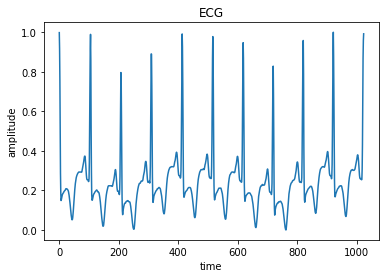

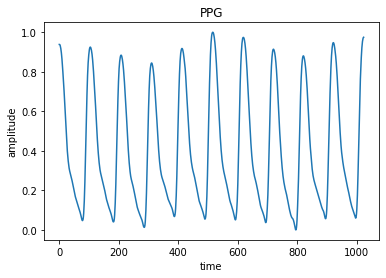

In [8]:
plt.plot(ECG.iloc[0,:].values);
plt.xlabel('time');
plt.ylabel('amplitude');
plt.title("ECG");

plt.figure();
plt.plot(PPG.iloc[0,:].values);
plt.xlabel('time');
plt.ylabel('amplitude');
plt.title("PPG");

In [9]:
X = PPG.values
input_shape = (X.shape[0],1024,1)
X = np.reshape(X,input_shape)
print("input shape is ",X.shape)
y= ECG.values
input_shape = (y.shape[0],1024,1)
y = np.reshape(y,input_shape)
print("output shape is ",y.shape)

input shape is  (30908, 1024, 1)
output shape is  (30908, 1024, 1)


In [10]:
X_train,X_test , y_train  , y_test = train_test_split(X , y , test_size = 0.11,shuffle=True)
print("train shape is ",X_train.shape)
print("test shape is ",X_test.shape)

train shape is  (27508, 1024, 1)
test shape is  (3400, 1024, 1)


In [11]:
# Define global constants to be used in this notebook
BATCH_SIZE=32
LATENT_DIM=32

In [12]:
import tensorflow_datasets as tfds

def get_dataset(training_df,is_validation=False):
  '''Loads and prepares the mnist dataset from TFDS'''
  if is_validation:
    split_name = "test"
  else:
    split_name = "train"
  
  tf.executing_eagerly()
  features = list(map(int,list(range(0,training_df.shape[1]))))
  training_dataset = (
  tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(training_df[features].values, tf.float32),
            
          )
          )
          )

  if is_validation:
    dataset = training_dataset.batch(BATCH_SIZE)
  else:
    dataset = training_dataset.shuffle(1024).batch(BATCH_SIZE)
  
  return dataset

In [13]:
dataset = get_dataset(PPG)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None),)>

In [14]:
train_dataset_ppg = get_dataset(PPG,True)
train_dataset_ecg = get_dataset(ECG,True)

In [15]:
train_dataset_ppg

<BatchDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None),)>

In [16]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with encoder output

    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """

    # unpack the output of the encoder
    mu, sigma = inputs

    # get the size and dimensions of the batch
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    # generate a random tensor
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

    # combine the inputs and noise
    return mu + tf.exp(0.5 * sigma) * epsilon

In [17]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space
  
  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_2.shape -- shape of the features before flattening
  """

  x = Conv1D(256, 5, activation="relu", padding="same")(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling1D(2, padding='same')(x)

  x = Conv1D(128, 5, activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(2, padding='same')(x)

  x = Conv1D(64, 3, activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(2, padding='same')(x)

  x = Conv1D(32,3, activation='relu', padding='same')(x)
  batch_2 = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)

  

  # we arbitrarily used 20 units here but feel free to change and see what results you get
  x = tf.keras.layers.Dense(20, activation="relu", name="encoder_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # add output Dense networks for mu and sigma, units equal to the declared latent_dim
  mu = tf.keras.layers.Dense(latent_dim, name="latent_mu")(x)
  sigma = tf.keras.layers.Dense(latent_dim, name="latent_sigma")(x)

  return mu, sigma, batch_2.shape

In [18]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer

  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """

  # declare the inputs tensor with the given shape
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get the output of the encoder_layers() function
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

  # feed mu and sigma to the sampling layer
  z = Sampling()((mu, sigma))

  # build the whole encoder model
  model = tf.keras.Model(inputs=inputs, outputs=[mu, sigma, z])

  return model, conv_shape

In [19]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layer
  Args:
    inputs -- output of the decoder
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """

  # feed to a Dense network with units computed from the conv_shape dimensions
  units = conv_shape[1] * conv_shape[2] 
  x = tf.keras.layers.Dense(units, activation="relu", name="decode_dense1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  # reshape output using the conv_shape dimensions
  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2]), name="decode_reshape")(x)

  # upsample the features back to the original dimensions
  x = Conv1D(32, 3, activation='relu', padding='same')(x)
  x = UpSampling1D(2)(x)
  x = Conv1D(64, 3, activation='relu', padding='same')(x)
  x = UpSampling1D(2)(x)
  x = Conv1D(128, 5, activation='relu', padding='same')(x)
  x = UpSampling1D(2)(x)
  x = Conv1D(256, 5, activation='relu', padding='same')(x)
  #x = UpSampling1D(2)(x)
  x = Conv1D(1, 5, activation='relu', padding='same')(x)

  return x

In [20]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model

  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening
  
  Returns:
    model -- the decoder model
  """

  # set the inputs to the shape of the latent space
  inputs = tf.keras.layers.Input(shape=(latent_dim,))

  # get the output of the decoder layers
  outputs = decoder_layers(inputs, conv_shape)

  # declare the inputs and outputs of the model
  model = tf.keras.Model(inputs, outputs)

  return model

In [21]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """Computes the Kullback-Leibler Divergence (KLD)
  
  Args:
    inputs -- batch from the dataset
    outputs -- batch from the sampling layer
    mu -- mean
    sigma -- standard deviation
  
  Returns
    KLD loss
  """
  # honestly, to truly understand this loss is challenging to me
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  kl_loss = tf.reduce_mean(kl_loss) * - 0.5

  return kl_loss


In [22]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """

  # set the inputs
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get mu, sigma, and z from the encoder output
  mu, sigma, z = encoder(inputs)

  # get reconstructed output from the encoder
  reconstructed = decoder(z)

  # define the inputs and outputs to the VAE
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  # add the KL loss
  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)

  return model


In [23]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  return encoder, decoder, vae

In [24]:
# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, vae = get_models(input_shape=(1024,1,), latent_dim=LATENT_DIM)

In [25]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 decode_dense1 (Dense)       (None, 4096)              135168    
                                                                 
 batch_normalization_5 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 decode_reshape (Reshape)    (None, 128, 32)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 128, 32)           3104      
                                                                 
 up_sampling1d (UpSampling1D  (None, 256, 32)          0         
 )                                                         

In [26]:
# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.MeanSquaredError()

In [27]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.plot(predictions[i, :, 0])
      

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

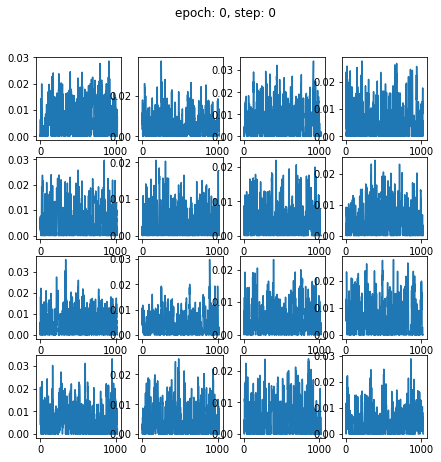

Start of epoch 0


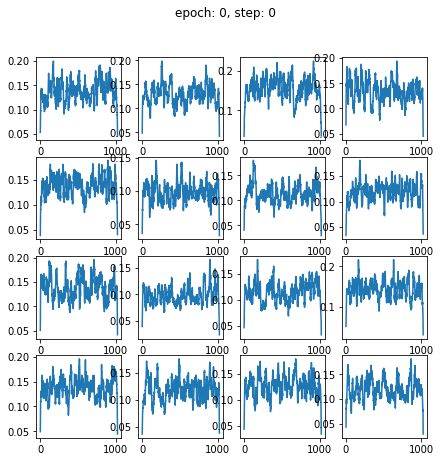

Epoch: 0 step: 0 mean loss = 82.365776


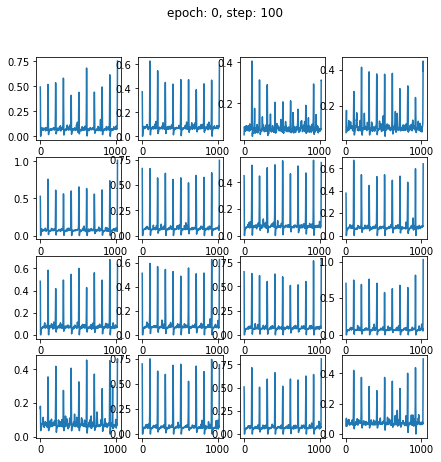

Epoch: 0 step: 100 mean loss = 30.329456


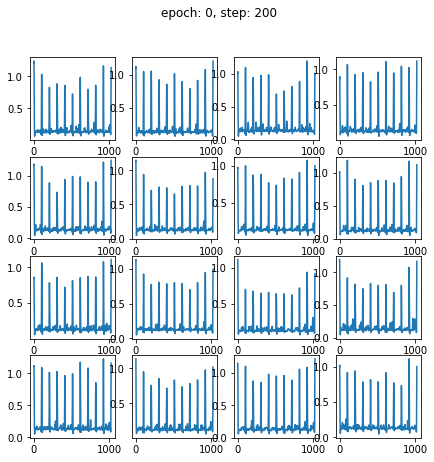

Epoch: 0 step: 200 mean loss = 29.654068


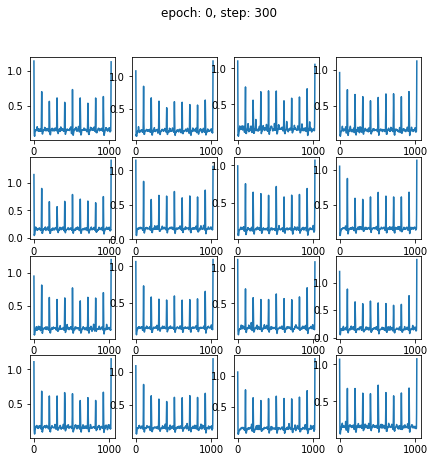

Epoch: 0 step: 300 mean loss = 27.107883


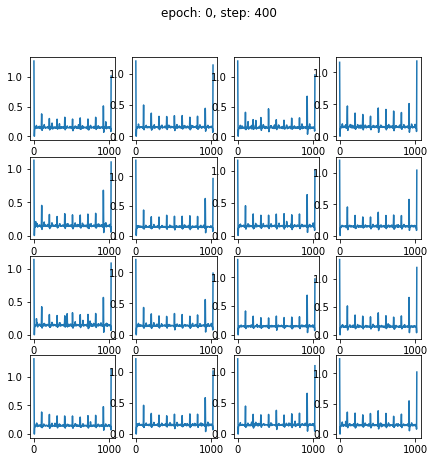

Epoch: 0 step: 400 mean loss = 29.160778


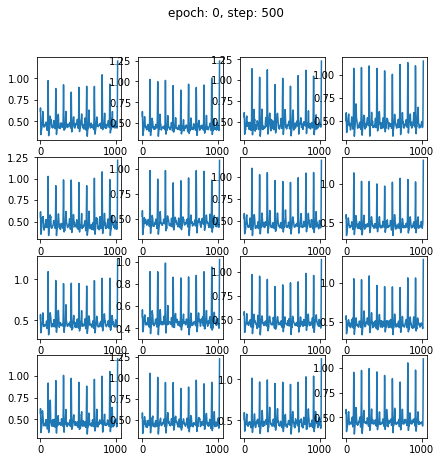

Epoch: 0 step: 500 mean loss = 34.350075


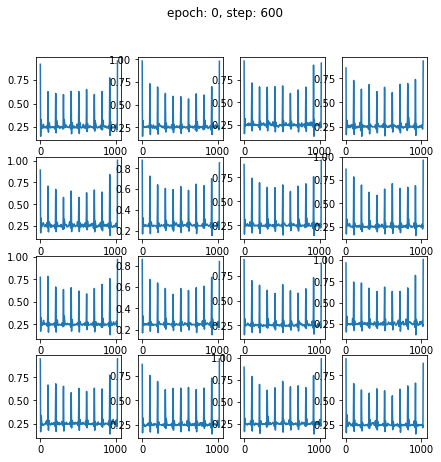

Epoch: 0 step: 600 mean loss = 32.38524


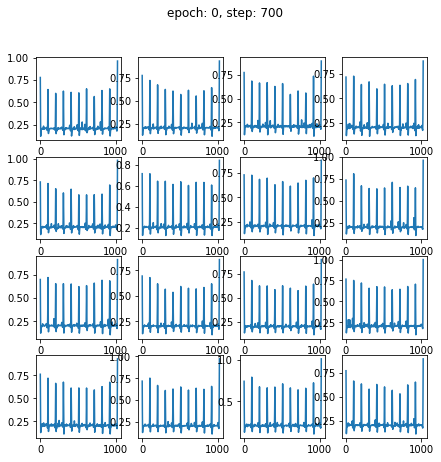

Epoch: 0 step: 700 mean loss = 32.55273


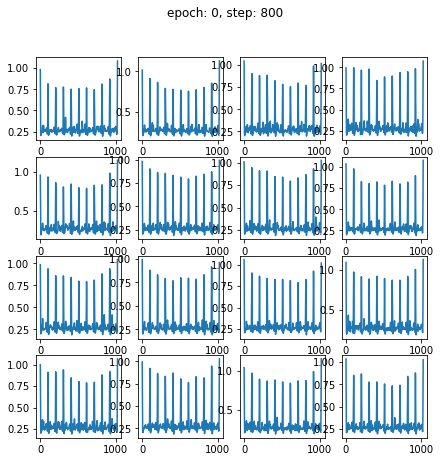

Epoch: 0 step: 800 mean loss = 30.91745


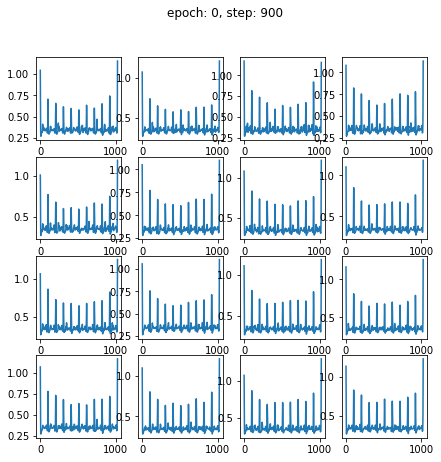

Epoch: 0 step: 900 mean loss = 32.034092
Start of epoch 1


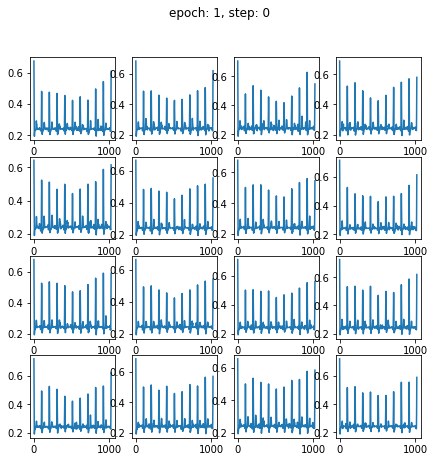

Epoch: 1 step: 0 mean loss = 32.68391


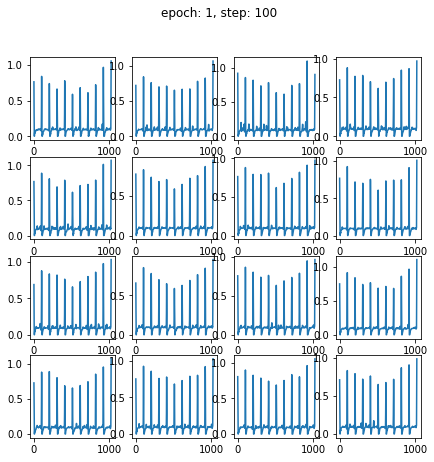

Epoch: 1 step: 100 mean loss = 32.667217


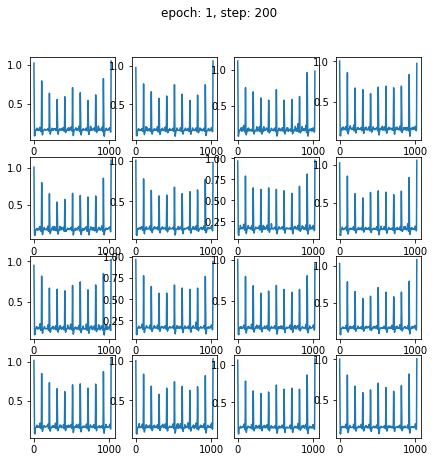

Epoch: 1 step: 200 mean loss = 32.18104


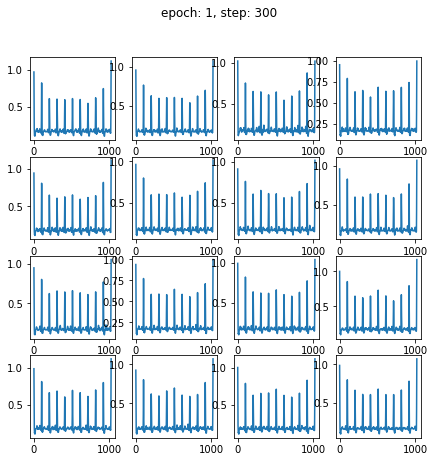

Epoch: 1 step: 300 mean loss = 31.167824


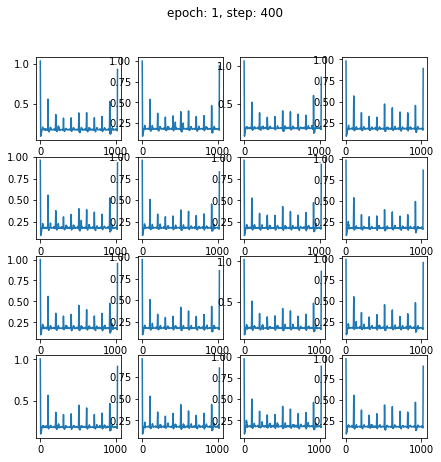

Epoch: 1 step: 400 mean loss = 31.245417


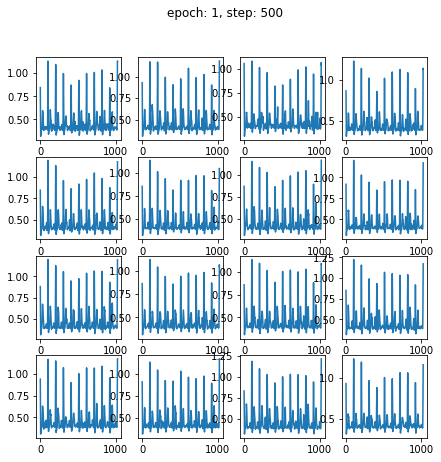

Epoch: 1 step: 500 mean loss = 32.651173


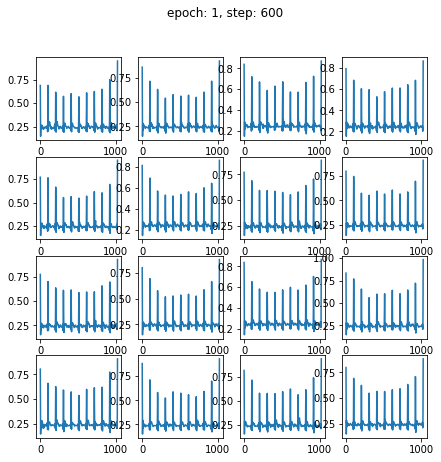

Epoch: 1 step: 600 mean loss = 32.097126


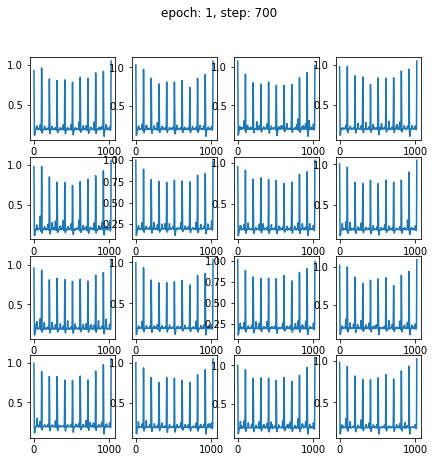

Epoch: 1 step: 700 mean loss = 32.16137


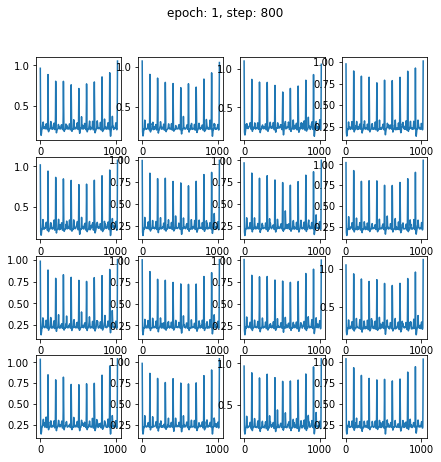

Epoch: 1 step: 800 mean loss = 31.424349


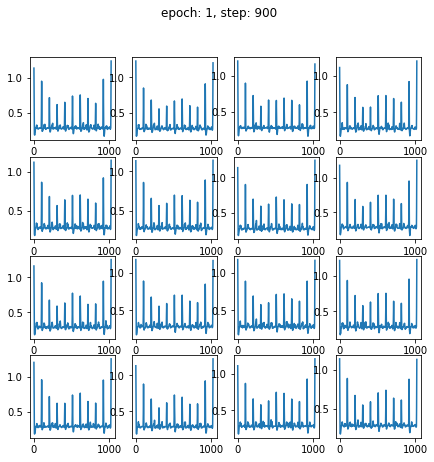

Epoch: 1 step: 900 mean loss = 31.8268
Start of epoch 2


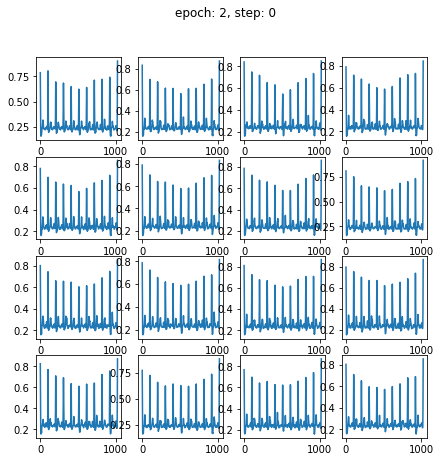

Epoch: 2 step: 0 mean loss = 32.078754


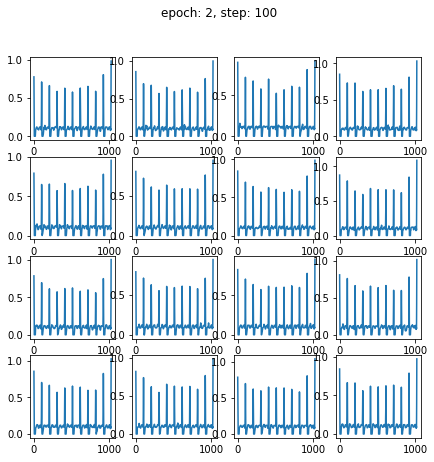

Epoch: 2 step: 100 mean loss = 31.993557


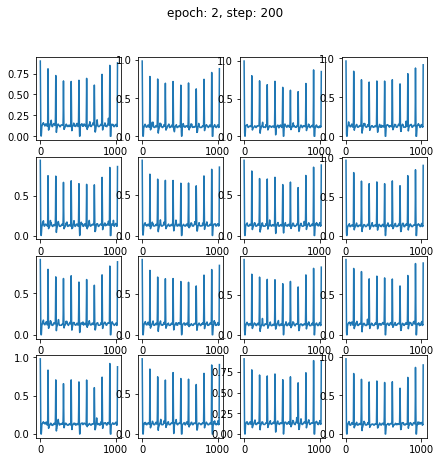

Epoch: 2 step: 200 mean loss = 31.792194


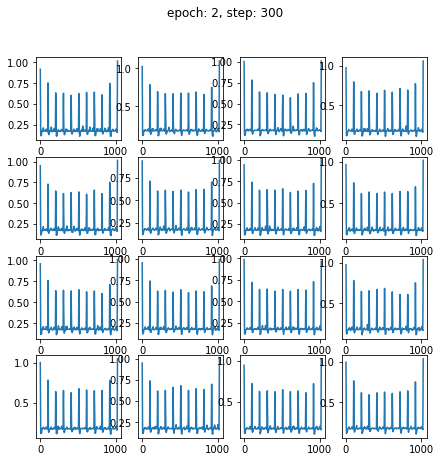

Epoch: 2 step: 300 mean loss = 31.315008


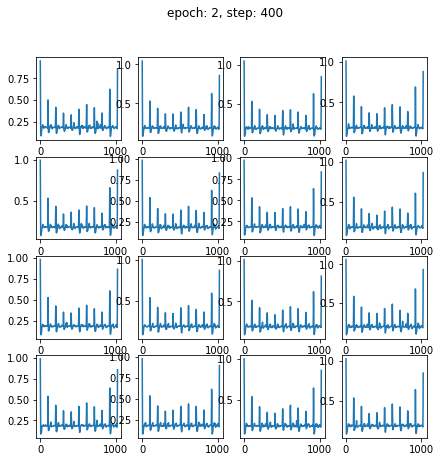

Epoch: 2 step: 400 mean loss = 31.341263


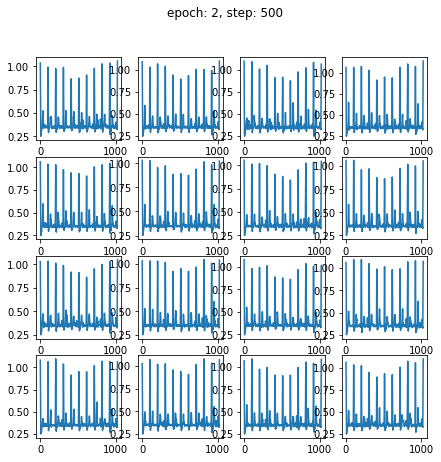

Epoch: 2 step: 500 mean loss = 32.118744


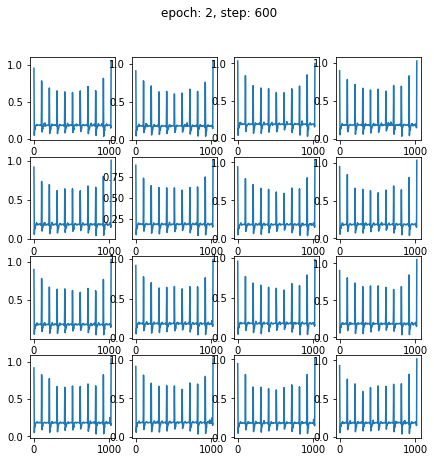

Epoch: 2 step: 600 mean loss = 31.836626


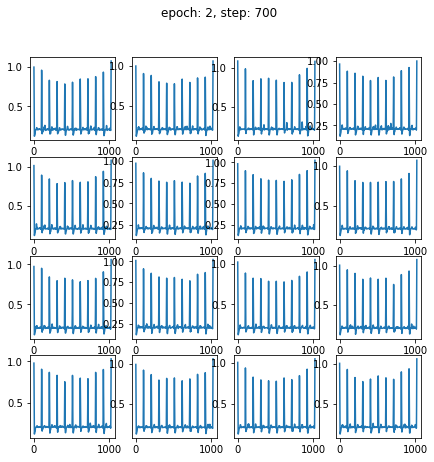

Epoch: 2 step: 700 mean loss = 31.82278


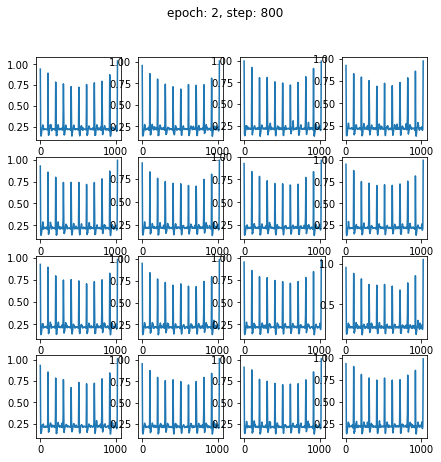

Epoch: 2 step: 800 mean loss = 31.373734


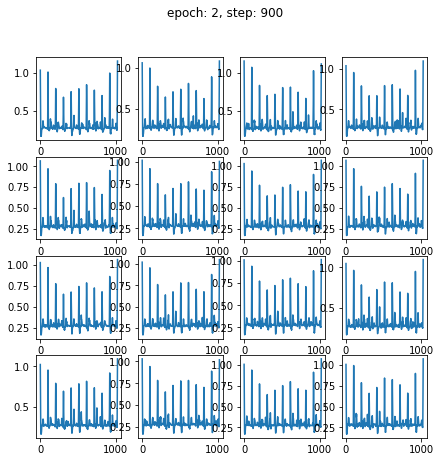

Epoch: 2 step: 900 mean loss = 31.637087
Start of epoch 3


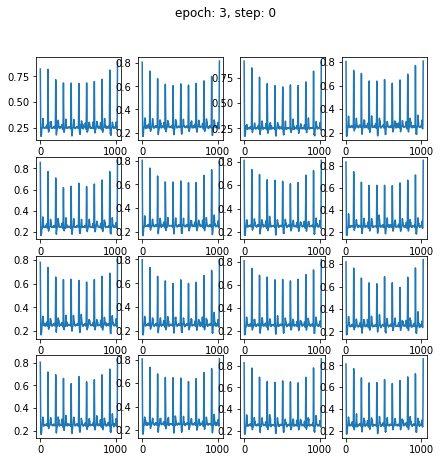

Epoch: 3 step: 0 mean loss = 31.81019


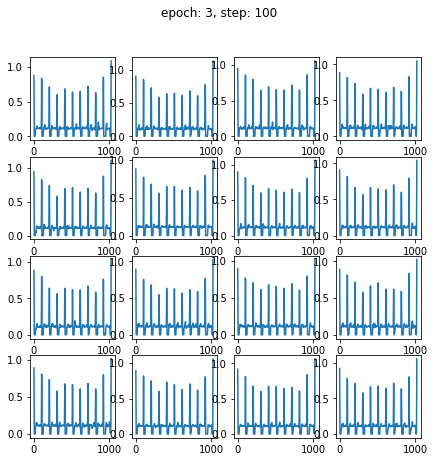

Epoch: 3 step: 100 mean loss = 31.757626


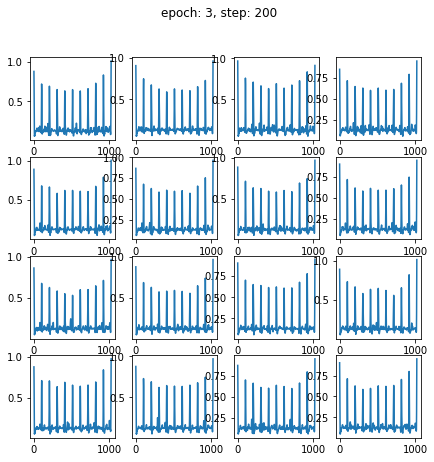

Epoch: 3 step: 200 mean loss = 31.635824


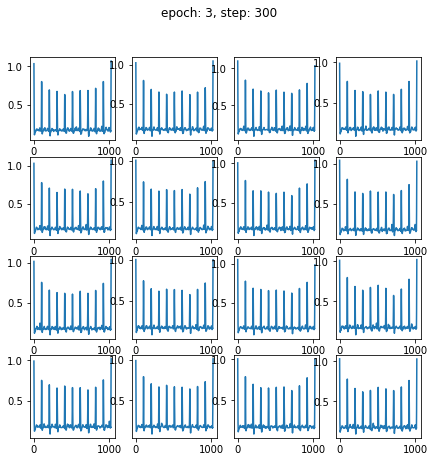

Epoch: 3 step: 300 mean loss = 31.279106


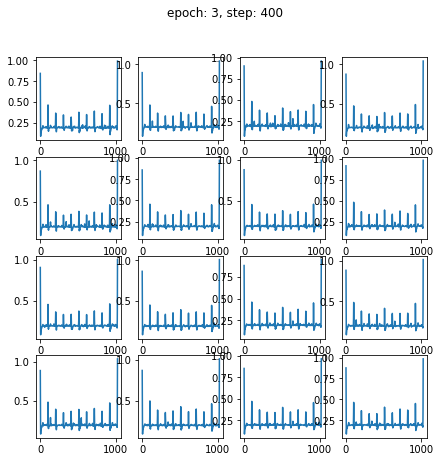

Epoch: 3 step: 400 mean loss = 31.297472


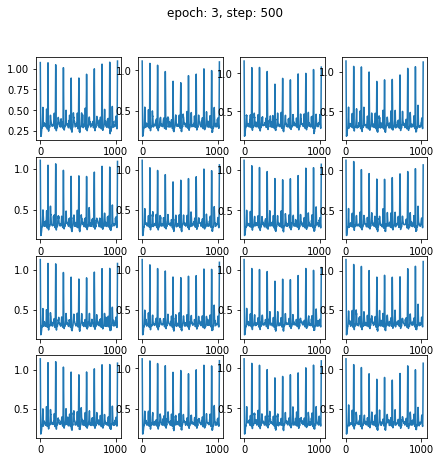

Epoch: 3 step: 500 mean loss = 31.836096


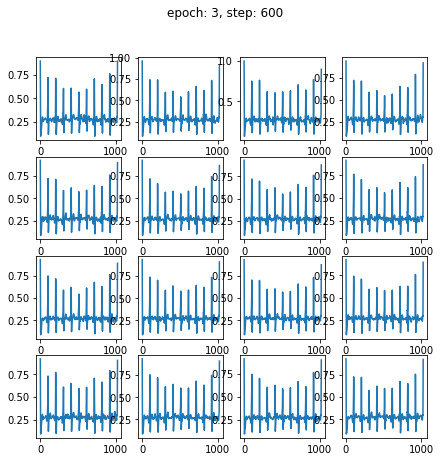

Epoch: 3 step: 600 mean loss = 31.574041


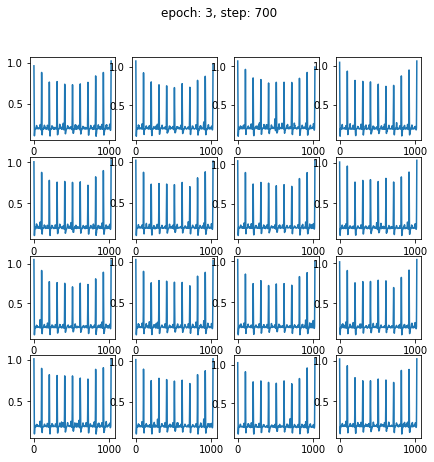

Epoch: 3 step: 700 mean loss = 31.576193


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f3a43c900e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 567, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
# Training loop

# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 100

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch, ))

  # iterate over the batches of the dataset
  for step ,i in enumerate(zip(train_dataset_ppg ,train_dataset_ecg)) :
    with tf.GradientTape() as tape:
      # feed a batch to the VAE model
      reconstructed = vae(i[0])

      # compute reconstruction loss
      flattened_inputs = tf.reshape(i[1], shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 1024  # image size (1024 * 1)
      
      # add KLD regularization loss
      loss += sum(vae.losses)

    # get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      #display.clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))